# Import Statements

In [223]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
import dominate
from dominate.tags import *
from espn_api.football import League

# Read the ESPN API to add to Dataset

### Load in league_id, espn_s2, and swid to connect to api

In [ ]:
league_id = 565994
espn_s2 = 'AECM5wfhjIj%2FgFWK7gldFYleiro5zx5YQV0NKDgcd1glbVuvTot8VFFUNWhPjAOG46Ut0lFYEI5mo75eeL5VDdQMyLKmpms7TetGiz2dMsUSIfl2A7MNQMrSMFvmBHhg0wi1SQbHOFKI6FBVsJqtBlq5c%2B%2Bl5dGvpM8LmhrFp563Dv4eaZhclj9lfSPq3CC4u%2FsUk7iSzQq42W7AUMVbYJqAKKX11dazM5GmocQozc9GXNKiRIhuNDAe2en7%2FjyAbJqSZEwlWu%2BRyOIyOpmLgr6wnx47jWxeKJmTIYP24Hk13Q%3D%3D'
swid = '{1B555C10-31F2-4EC7-A015-90782392E593}'

### Run this cell to run the API and pull in all records

In [311]:
home_teams = []
away_teams = []
home_scores = []
away_scores = []
home_projs = []
away_projs = []
playoff = []
weeks = []
years = []

for year in range(2019,2025):
    
    league = League(league_id=league_id, year=year, espn_s2=espn_s2, swid=swid)
    team_dict = {team:team.owners[0]['firstName'] for team in league.teams}
    team_dict[0] = 'Bye'

    season_length = 17
    if year in [2019,2020]:
        season_length = 16

    for week in range(1,season_length + 1):
        
        for matchup in league.box_scores(week):
            
            if (matchup.matchup_type in ['NONE','WINNERS_BRACKET']):
                years.append(year)
                weeks.append(week)
                playoff.append(matchup.is_playoff)
                home_teams.append(team_dict[matchup.home_team])
                home_scores.append(matchup.home_score)
                home_projs.append(matchup.home_projected)
                away_teams.append(team_dict[matchup.away_team])
                away_scores.append(matchup.away_score)
                away_projs.append(matchup.away_projected)
            else:
                pass
            
            

df = pd.DataFrame({
        'Year':years,
        'Week':weeks,
        'Playoff Flag':playoff,
        'Home Team':home_teams,
        'Home Score':home_scores,
        'Home Projection':home_projs,
        'Away Team':away_teams,
        'Away Score':away_scores,
        'Away Projection':away_projs
    })

In [319]:
df.loc[(df['Playoff Flag']) & (df['Year'] == 2020)]

,Year,Week,Playoff Flag,Home Team,Home Score,Home Projection,Away Team,Away Score,Away Projection
150,2020,14,True,Ethan,96.42,133.03,Bye,0.00,0.00
151,2020,14,True,Noah,140.68,143.30,Andrew,123.42,124.52
152,2020,14,True,Dante,119.14,127.12,Carter,103.16,123.76
153,2020,14,True,Michael,95.06,110.21,Bye,0.00,0.00
154,2020,15,True,Ethan,145.76,126.16,Noah,133.16,143.99
155,2020,15,True,Michael,144.32,121.74,Dante,119.24,120.18
156,2020,16,True,Ethan,143.14,143.14,Michael,100.96,100.96


# Load in Historical Data and Write to new Files

In [321]:
del round

### Run this cell to overwrite the CSV files with the newest run of the API

In [322]:
df['Home Team'] = df['Home Team'].replace({'The':'Klapp', 'Noah ':'Noah'})
df['Away Team'] = df['Away Team'].replace({'The':'Klapp', 'Noah ':'Noah'})

df.to_csv('database/fantasy-football-matchup-data.csv')

temp1 = df[['Year','Week','Playoff Flag','Home Team','Home Score','Away Score']].copy()
temp2 = df[['Year','Week','Playoff Flag','Away Team','Away Score','Home Score']].copy()

temp1.rename(columns={'Home Team':'Team', 'Home Score':'Score', 'Away Score':'Opp Score'}, inplace=True)
temp2.rename(columns={'Away Team':'Team', 'Away Score':'Score', 'Home Score':'Opp Score'}, inplace=True)

df_converted = pd.concat([temp1,temp2], axis=0, ignore_index=True)
df_converted['Win'] = df_converted['Score'] > df_converted['Opp Score']
df_converted['Win'] = df_converted['Win'].map(int)
df_converted['Margin'] = round(df_converted['Score'] - df_converted['Opp Score'], 2)

df_converted.sort_values(['Year','Week'], inplace = True)
df_converted.to_csv('database/fantasy-football-game-data.csv')
df_converted

,Year,Week,Playoff Flag,Team,Score,Opp Score,Win,Margin
0,2019,1,False,Justin,158.02,113.20,1,44.82
1,2019,1,False,Dante,107.92,126.14,0,-18.22
2,2019,1,False,Michael,112.68,134.32,0,-21.64
3,2019,1,False,Andrew,128.54,141.26,0,-12.72
4,2019,1,False,Haris,135.80,101.82,1,33.98
...,...,...,...,...,...,...,...,...
505,2024,16,True,Andrew,117.28,134.34,0,-17.06
1011,2024,16,True,Zach,139.88,136.02,1,3.86
1012,2024,16,True,Noah,134.34,117.28,1,17.06
506,2024,17,True,Zach,128.60,89.22,1,39.38


# Constant Files + Helper Functions

In [407]:
MATCHUP_DATA = pd.read_csv('database/fantasy-football-matchup-data.csv')
GAME_DATA = pd.read_csv('database/fantasy-football-game-data.csv')
TEAMS = GAME_DATA.loc[~ GAME_DATA['Playoff Flag'], 'Team'].unique()
YEARS = GAME_DATA['Year'].unique()
YEARS_WEEKS = [(year, GAME_DATA.loc[(GAME_DATA['Year'] == year) & (GAME_DATA['Playoff Flag'] == False), 'Week'].max()) for year in YEARS]

### Helper Functions (df_to_table, luck score functions)

In [370]:
def df_to_table(data: pd.DataFrame) -> table:
    t = table()
    head = thead()
    body = tbody()

    column_row = tr()
    for column in data.columns:
        column_row.add(th(column))
    head.add(column_row)
    
    for row in data.values:
        r = tr()
        for value in row:
            r.add(td(value))
        body.add(r)

    t.add(head)
    t.add(body)

    return t

def opp_luck_score(opp_score, mean=None, std=None):
    return int(((mean - opp_score) / np.absolute(mean - opp_score)) * np.floor(np.absolute(mean - opp_score) / std))

def your_luck_score(your_score, opp_score, mean=None, std=None):
    xi = lambda x: np.floor((mean + x) / (2*mean))
    result = int(your_score > opp_score)
    return int(np.floor(np.absolute(mean - your_score) / std) * (result * xi(2*mean - your_score) - (1-result) * xi(your_score)))
    
def close_luck_score(your_score, opp_score):
    close_game_flag = int(abs(your_score - opp_score) < 3)
    win_flag = int(your_score > opp_score)
    loss_flag = -int(your_score < opp_score)

    return (close_game_flag * win_flag) + (close_game_flag * loss_flag)

def summary_table(data: pd.DataFrame, year: int, week: int = None) -> pd.DataFrame:
    temp = data.loc[(data['Year'] == year) & (data['Playoff Flag'] == False)].copy()

    if week != None:
        temp = temp.loc[(data['Week'] <= week)]

    mean = temp['Score'].mean()
    std = temp['Score'].std() * 0.5

    opp_luck = []
    your_luck = []
    close_luck = []

    for your_score, opp_score in temp[['Score','Opp Score']].values:
        opp_luck.append(opp_luck_score(opp_score=opp_score, mean=mean, std=std))
        your_luck.append(your_luck_score(your_score=your_score, opp_score=opp_score, mean=mean, std=std))
        close_luck.append(close_luck_score(your_score=your_score, opp_score=opp_score))

    temp['Opp Luck Score'] = opp_luck
    temp['Your Luck Score'] = your_luck
    temp['Close Luck Score'] = close_luck

    temp['Luck Score'] = temp[['Opp Luck Score','Your Luck Score','Close Luck Score']].sum(axis=1)

    temp_teams = temp['Team'].unique()
    weekly_standings = []

    for team in temp_teams:
        temp_team = temp.loc[temp['Team'] == team]
        wins = temp_team['Win'].sum()
        losses = temp_team['Win'].eq(0).sum()
        record = f'{wins}-{losses}'

        pf = round(temp_team['Score'].sum(), 2)
        avg_pf = round(pf / len(temp_team), 2)
        pa = round(temp_team['Opp Score'].sum(), 2)
        avg_margin = round((pf - pa) / len(temp_team), 2)
        luck_score = temp_team['Luck Score'].sum()

        weekly_standings.append([team, wins, record, pf, pa, avg_pf, avg_margin, luck_score])

    weekly_standings = pd.DataFrame(weekly_standings, columns=['Team','Wins','Record', 'Points For','Points Against','Avg Points For','Avg Margin','Luck Score'])
    weekly_standings.sort_values(['Wins','Points For'], ascending=False, ignore_index=True, inplace=True)
    weekly_standings['Ranking'] = [i + 1 for i in weekly_standings.index]
    weekly_standings['Year'] = year
    weekly_standings = weekly_standings[['Year','Team','Record','Ranking','Points For','Points Against','Avg Points For','Avg Margin','Luck Score']]

    return weekly_standings

In [373]:
d = summary_table(GAME_DATA, year = 2023).drop('Year', axis = 1)
d

,Team,Record,Ranking,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
0,Haris,12-2,1,1801.34,1456.30,128.67,24.65,10
1,Carter,11-3,2,1787.82,1538.86,127.70,17.78,9
2,Ethan,9-5,3,1574.82,1510.76,112.49,4.58,7
3,Andrew,8-6,4,1672.62,1532.50,119.47,10.01,2
4,Michael,8-6,5,1575.84,1666.08,112.56,-6.45,1
5,Kevin,7-7,6,1800.40,1696.42,128.60,7.43,-8
6,Noah,7-7,7,1579.60,1669.46,112.83,-6.42,-1
7,Dante,6-8,8,1689.52,1667.06,120.68,1.60,-6
8,Nathan,6-8,9,1496.26,1648.44,106.88,-10.87,4
9,Zach,4-10,10,1488.32,1699.04,106.31,-15.05,-4


# Week Content

## Weekly Scoreboard Table





In [102]:
year = 2022
week = 10

scoreboard = MATCHUP_DATA.loc[(MATCHUP_DATA['Year'] == year) & (MATCHUP_DATA['Week'] == week), ['Home Team','Home Score','Away Score','Away Team']]
scoreboard

,Home Team,Home Score,Away Score,Away Team
284,Kevin,117.68,102.70,Dante
285,Ethan,116.40,102.56,Andrew
286,Haris,102.34,139.04,Carter
287,Michael,123.00,88.60,Zach
288,Tyler,97.90,106.92,McGwire
289,Noah,122.48,104.38,Nathan


In [103]:
print(df_to_table(scoreboard))

<table>
  <thead>
    <tr>
      <th>Home Team</th>
      <th>Home Score</th>
      <th>Away Score</th>
      <th>Away Team</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Kevin</td>
      <td>117.68</td>
      <td>102.7</td>
      <td>Dante</td>
    </tr>
    <tr>
      <td>Ethan</td>
      <td>116.4</td>
      <td>102.56</td>
      <td>Andrew</td>
    </tr>
    <tr>
      <td>Haris</td>
      <td>102.34</td>
      <td>139.04</td>
      <td>Carter</td>
    </tr>
    <tr>
      <td>Michael</td>
      <td>123.0</td>
      <td>88.6</td>
      <td>Zach</td>
    </tr>
    <tr>
      <td>Tyler</td>
      <td>97.9</td>
      <td>106.92</td>
      <td>McGwire</td>
    </tr>
    <tr>
      <td>Noah </td>
      <td>122.48</td>
      <td>104.38</td>
      <td>Nathan</td>
    </tr>
  </tbody>
</table>


## Weekly Standings Update Table (with Luck Scores)

In [269]:
year = 2022
week = 2

temp = GAME_DATA.loc[(GAME_DATA['Year'] == year) & (GAME_DATA['Week'] <= week)].copy()

mean = temp['Score'].mean()
std = temp['Score'].std() * 0.5

opp_luck = []
your_luck = []
close_luck = []

for your_score, opp_score in temp[['Score','Opp Score']].values:
    opp_luck.append(opp_luck_score(opp_score=opp_score, mean=mean, std=std))
    your_luck.append(your_luck_score(your_score=your_score, opp_score=opp_score, mean=mean, std=std))
    close_luck.append(close_luck_score(your_score=your_score, opp_score=opp_score))

temp['Opp Luck Score'] = opp_luck
temp['Your Luck Score'] = your_luck
temp['Close Luck Score'] = close_luck

temp['Luck Score'] = temp[['Opp Luck Score','Your Luck Score','Close Luck Score']].sum(axis=1)

temp_teams = temp['Team'].unique()
weekly_standings = []

for team in temp_teams:
    temp_team = temp.loc[temp['Team'] == team]
    wins = temp_team['Win'].sum()
    losses = week - wins
    record = f'{wins}-{losses}'

    pf = round(temp_team['Score'].sum(), 2)
    avg_pf = round(pf / week, 2)
    pa = round(temp_team['Opp Score'].sum(), 2)
    avg_margin = round((pf - pa) / week, 2)
    luck_score = temp_team['Luck Score'].sum()

    weekly_standings.append([team, wins, record, pf, pa, avg_pf, avg_margin, luck_score])

weekly_standings = pd.DataFrame(weekly_standings, columns=['Team','Wins','Record', 'Points For','Points Against','Avg Points For','Avg Margin','Luck Score'])
weekly_standings.sort_values(['Wins','Points For'], ascending=False, ignore_index=True, inplace=True)
weekly_standings = weekly_standings[['Team','Record','Points For','Points Against','Avg Points For','Avg Margin','Luck Score']]
weekly_standings

,Team,Record,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
0,Andrew,2-0,268.20,252.72,134.10,7.74,-1
1,Michael,2-0,255.34,191.04,127.67,32.15,3
2,Zach,2-0,235.66,203.68,117.83,15.99,1
3,Dante,2-0,225.26,167.96,112.63,28.65,5
4,Haris,1-1,280.22,248.36,140.11,15.93,-2
5,Noah,1-1,272.04,227.72,136.02,22.16,1
6,Carter,1-1,239.50,206.90,119.75,16.30,2
7,Kevin,1-1,228.08,270.58,114.04,-21.25,-3
8,McGwire,0-2,226.38,251.66,113.19,-12.64,-2
9,Ethan,0-2,204.16,265.74,102.08,-30.79,-2


# Year Content

#### Regular Season Final Standings Table (with Luck Scores)

In [344]:
year = 2023

temp = GAME_DATA.loc[(GAME_DATA['Year'] == year) & (GAME_DATA['Playoff Flag'] == False)].copy()

mean = temp['Score'].mean()
std = temp['Score'].std() * 0.5

opp_luck = []
your_luck = []
close_luck = []

for your_score, opp_score in temp[['Score','Opp Score']].values:
    opp_luck.append(opp_luck_score(opp_score=opp_score, mean=mean, std=std))
    your_luck.append(your_luck_score(your_score=your_score, opp_score=opp_score, mean=mean, std=std))
    close_luck.append(close_luck_score(your_score=your_score, opp_score=opp_score))

temp['Opp Luck Score'] = opp_luck
temp['Your Luck Score'] = your_luck
temp['Close Luck Score'] = close_luck

temp['Luck Score'] = temp[['Opp Luck Score','Your Luck Score','Close Luck Score']].sum(axis=1)

temp_teams = temp['Team'].unique()
weekly_standings = []

for team in temp_teams:
    temp_team = temp.loc[temp['Team'] == team]
    wins = temp_team['Win'].sum()
    losses = temp_team['Win'].eq(0).sum()
    record = f'{wins}-{losses}'

    pf = round(temp_team['Score'].sum(), 2)
    avg_pf = round(pf / len(temp_team), 2)
    pa = round(temp_team['Opp Score'].sum(), 2)
    avg_margin = round((pf - pa) / len(temp_team), 2)
    luck_score = temp_team['Luck Score'].sum()

    weekly_standings.append([team, wins, record, pf, pa, avg_pf, avg_margin, luck_score])

weekly_standings = pd.DataFrame(weekly_standings, columns=['Team','Wins','Record', 'Points For','Points Against','Avg Points For','Avg Margin','Luck Score'])
weekly_standings.sort_values(['Wins','Points For'], ascending=False, ignore_index=True, inplace=True)
weekly_standings['Ranking'] = [i + 1 for i in weekly_standings.index]
weekly_standings = weekly_standings[['Team','Record','Ranking','Points For','Points Against','Avg Points For','Avg Margin','Luck Score']]

weekly_standings

,Team,Record,Ranking,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
0,Haris,12-2,1,1801.34,1456.30,128.67,24.65,10
1,Carter,11-3,2,1787.82,1538.86,127.70,17.78,9
2,Ethan,9-5,3,1574.82,1510.76,112.49,4.58,7
3,Andrew,8-6,4,1672.62,1532.50,119.47,10.01,2
4,Michael,8-6,5,1575.84,1666.08,112.56,-6.45,1
5,Kevin,7-7,6,1800.40,1696.42,128.60,7.43,-8
6,Noah,7-7,7,1579.60,1669.46,112.83,-6.42,-1
7,Dante,6-8,8,1689.52,1667.06,120.68,1.60,-6
8,Nathan,6-8,9,1496.26,1648.44,106.88,-10.87,4
9,Zach,4-10,10,1488.32,1699.04,106.31,-15.05,-4


In [382]:
standings = summary_table(GAME_DATA, year = 2023)
standings

,Year,Team,Record,Ranking,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
0,2023,Haris,12-2,1,1801.34,1456.30,128.67,24.65,10
1,2023,Carter,11-3,2,1787.82,1538.86,127.70,17.78,9
2,2023,Ethan,9-5,3,1574.82,1510.76,112.49,4.58,7
3,2023,Andrew,8-6,4,1672.62,1532.50,119.47,10.01,2
4,2023,Michael,8-6,5,1575.84,1666.08,112.56,-6.45,1
5,2023,Kevin,7-7,6,1800.40,1696.42,128.60,7.43,-8
6,2023,Noah,7-7,7,1579.60,1669.46,112.83,-6.42,-1
7,2023,Dante,6-8,8,1689.52,1667.06,120.68,1.60,-6
8,2023,Nathan,6-8,9,1496.26,1648.44,106.88,-10.87,4
9,2023,Zach,4-10,10,1488.32,1699.04,106.31,-15.05,-4


In [389]:
color_dict = {'andrew':'cornflowerblue',
              'mcgwire':'darkblue',
              'tyler':'lightgreen',
              'noah':'#33a02c',
              'michael':'#fb9a99',
              'haris':'#e31a1c',
              'dante':'sandybrown',
              'nathan':'#ff7f00',
              'kevin':'violet',
              'ethan':'#6a3d9a',
              'zach':'gold',
              'carter':'#b15928'}

In [391]:
s = [(team, pf, pa, color_dict[team.lower()]) for team, pf, pa in zip(standings['Team'], standings['Points For'], standings['Points Against'])]
s

[('Haris', 1801.34, 1456.3, '#e31a1c'),
 ('Carter', 1787.82, 1538.86, '#b15928'),
 ('Ethan', 1574.82, 1510.76, '#6a3d9a'),
 ('Andrew', 1672.62, 1532.5, 'cornflowerblue'),
 ('Michael', 1575.84, 1666.08, '#fb9a99'),
 ('Kevin', 1800.4, 1696.42, 'violet'),
 ('Noah', 1579.6, 1669.46, '#33a02c'),
 ('Dante', 1689.52, 1667.06, 'sandybrown'),
 ('Nathan', 1496.26, 1648.44, '#ff7f00'),
 ('Zach', 1488.32, 1699.04, 'gold'),
 ('Tyler', 1534.28, 1766.36, 'lightgreen'),
 ('McGwire', 1509.26, 1658.8, 'darkblue')]

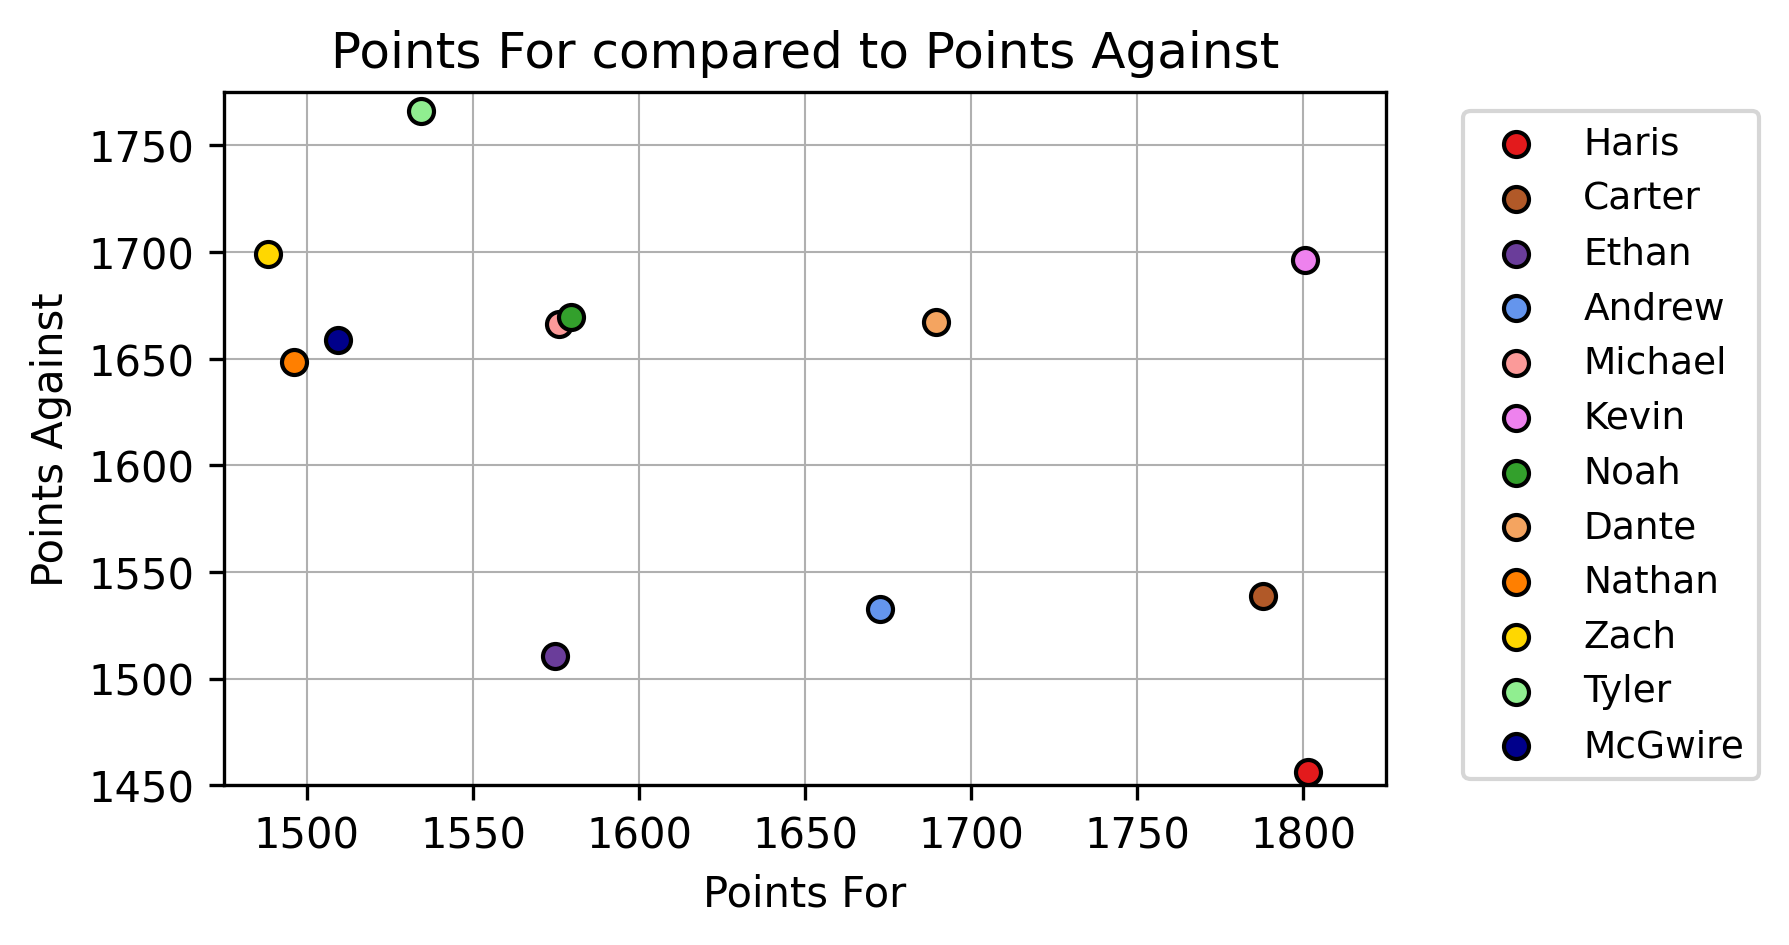

In [ ]:
plt.figure(figsize = (5,3), dpi = 300)
plt.grid(linewidth = 0.5, zorder = 0)
for team, pf, pa, color in s:
    plt.scatter(pf, pa, c = color, label = team, zorder = 3, edgecolor = 'k')
plt.xlim(int(standings['Points For'].min() - 4) - (int(standings['Points For'].min()-4) % 25),
         int(standings['Points For'].max() + 4) + 25 - (int(standings['Points For'].max() + 4) % 25)) # Automatically finds nearest 25 below/above for range
plt.ylim(int(standings['Points Against'].min() - 4) - (int(standings['Points Against'].min() - 4) % 25),
         int(standings['Points Against'].max() + 4) + 25 - (int(standings['Points Against'].max() + 4) % 25))
plt.xlabel('Points For')
plt.ylabel('Points Against')
plt.title('Points For compared to Points Against')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 9)
plt.savefig(f'PF-vs-PA-{year}.png')

# Champions Table

In [211]:
champions = df_converted.loc[(df_converted['Week'] == 17) & (df_converted['Win'] == 1), ['Year','Team']].values
champions

array([[2019, 'Dante'],
       [2020, 'Ethan'],
       [2021, 'Andrew'],
       [2022, 'Dante'],
       [2023, 'Haris'],
       [2024, 'Zach']], dtype=object)

In [226]:
data = []
for year, team in champions:
    temp = df_converted.loc[(df_converted['Year'] == year) & (df_converted['Team'] == team) & (df_converted['Playoff Flag'] == False)]
    wins = temp['Win'].sum()
    losses = len(temp) - wins
    record = f'{wins}-{losses}'

    pf = round(temp['Score'].sum(), 2)
    avg_pf = round(pf / len(temp), 2)
    pa = round(temp['Opp Score'].sum(), 2)
    avg_margin = round((pf - pa) / len(temp), 2)

    data.append([year, team, record, pf, avg_pf, avg_margin])
    
pd.DataFrame(data, columns=['Year','Team','Record','Points For','Avg Points For','Avg Margin'])

,Year,Team,Record,Points For,Avg Points For,Avg Margin
0,2019,Dante,8-5,1612.06,124.00,9.25
1,2020,Ethan,11-2,1639.56,126.12,22.44
2,2021,Andrew,10-4,1901.54,135.82,10.45
3,2022,Dante,10-4,1747.00,124.79,12.49
4,2023,Haris,12-2,1801.34,128.67,24.65
5,2024,Zach,8-6,1762.04,125.86,6.56


In [232]:
years = np.arange(2019,2025)
for year in years:
    if year < 2021:
        weeks = np.arange(1,14)
    else:
        weeks = np.arange(1,15)
    print(weeks)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


# Team Content

### Summary table by seasons

In [395]:
seasons = [summary_table(GAME_DATA, year=year) for year in YEARS]
seasons_df = pd.concat(seasons)

seasons_df = seasons_df.loc[seasons_df['Team'] == 'Haris'].drop('Team', axis = 1)
seasons_df

,Year,Record,Ranking,Points For,Points Against,Avg Points For,Avg Margin,Luck Score
4,2019,7-6,5,1548.30,1483.26,119.10,5.00,1
9,2020,3-10,10,1440.82,1773.88,110.83,-25.62,-13
2,2021,8-6,3,1855.22,1655.12,132.52,14.29,4
6,2022,7-7,7,1647.48,1579.54,117.68,4.85,-3
0,2023,12-2,1,1801.34,1456.30,128.67,24.65,10
9,2024,3-11,10,1468.60,1616.88,104.90,-10.59,1


Text(0.5, 1.0, 'Points For compared to Points Against')

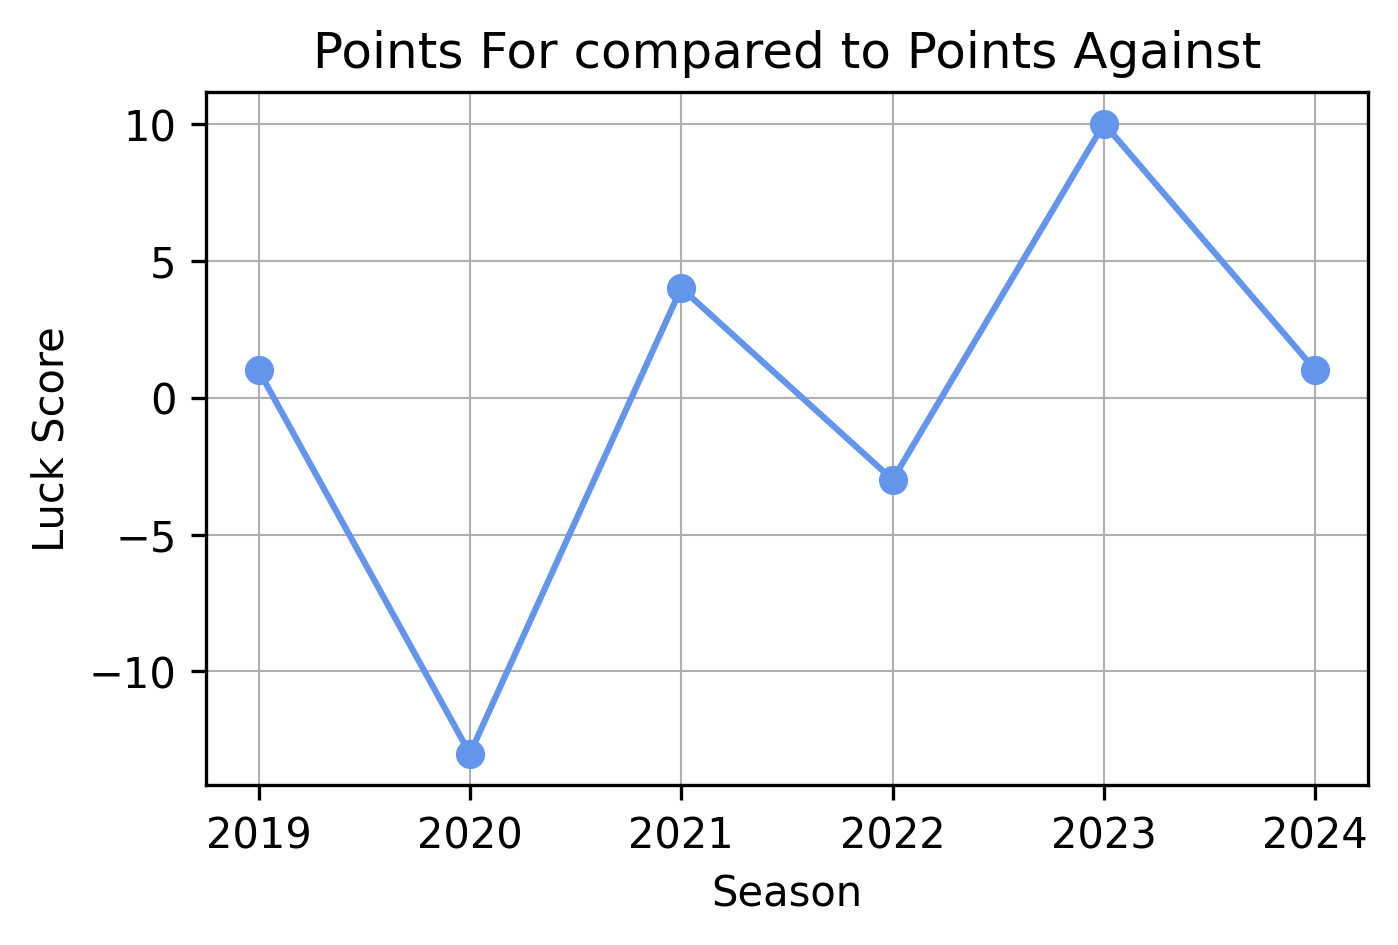

In [ ]:
plt.figure(figsize = (5,3), dpi = 300)
plt.grid(linewidth = 0.5, zorder = 0)
plt.plot(seasons_df['Year'], seasons_df['Luck Score'], c = 'cornflowerblue', marker = 'o', zorder = 3)
plt.xlabel('Season')
plt.ylabel('Luck Score')
plt.title('Points For compared to Points Against')
# plt.savefig(f'PF-vs-PA-{year}.png')

In [86]:
color_dict = {'andrew':'cornflowerblue',
              'mcgwire':'darkblue',
              'tyler':'lightgreen',
              'noah':'#33a02c',
              'michael':'#fb9a99',
              'haris':'#e31a1c',
              'dante':'sandybrown',
              'nathan':'#ff7f00',
              'kevin':'violet',
              'ethan':'#6a3d9a',
              'zach':'gold',
              'carter':'#b15928'}

In [9]:
query = '''
    SELECT *
    FROM results
'''

query += 'WHERE week = 4 AND year = 2022'

conn = sqlite3.connect('database/fantasy-football.db')

df = pd.read_sql(query, con=conn)

conn.close()

print(df)


    index  Year  Week  Playoff Flag     Team   Score  Opp Score Result
0     248  2022     4             0    Kevin  127.24     113.96    Win
1     249  2022     4             0   Nathan  125.08      85.28    Win
2     250  2022     4             0  McGwire   79.20     107.86   Loss
3     251  2022     4             0     Zach  150.22     133.80    Win
4     252  2022     4             0   Carter  102.46     107.50   Loss
5     253  2022     4             0   Andrew  134.68     180.24   Loss
6     745  2022     4             0    Noah   113.96     127.24   Loss
7     746  2022     4             0    Tyler   85.28     125.08   Loss
8     747  2022     4             0  Michael  107.86      79.20    Win
9     748  2022     4             0    Haris  133.80     150.22   Loss
10    749  2022     4             0    Ethan  107.50     102.46    Win
11    750  2022     4             0    Dante  180.24     134.68    Win


# Requests to Github page + API

In [6]:
import requests
from bs4 import BeautifulSoup

In [21]:
df_converted.to_json('api/data.json', orient='records', indent=2)

In [23]:
url = 'https://serdarevichar8.github.io/fantasy-football-website/api/data.json'

r = requests.get(url)

if not r.ok:
    print(r.status_code)

print(r.status_code)
print(r.text)

200
[
  {
    "Year":2019,
    "Week":1,
    "Playoff Flag":false,
    "Team":"Justin",
    "Score":158.02,
    "Opp Score":113.2,
    "Win":1
  },
  {
    "Year":2019,
    "Week":1,
    "Playoff Flag":false,
    "Team":"Dante",
    "Score":107.92,
    "Opp Score":126.14,
    "Win":0
  },
  {
    "Year":2019,
    "Week":1,
    "Playoff Flag":false,
    "Team":"Michael",
    "Score":112.68,
    "Opp Score":134.32,
    "Win":0
  },
  {
    "Year":2019,
    "Week":1,
    "Playoff Flag":false,
    "Team":"Andrew",
    "Score":128.54,
    "Opp Score":141.26,
    "Win":0
  },
  {
    "Year":2019,
    "Week":1,
    "Playoff Flag":false,
    "Team":"Haris",
    "Score":135.8,
    "Opp Score":101.82,
    "Win":1
  },
  {
    "Year":2019,
    "Week":1,
    "Playoff Flag":false,
    "Team":"Noah ",
    "Score":153.86,
    "Opp Score":132.22,
    "Win":1
  },
  {
    "Year":2019,
    "Week":1,
    "Playoff Flag":false,
    "Team":"Klapp",
    "Score":113.2,
    "Opp Score":158.02,
    "Win":0
  },

In [78]:
MATCHUP_DATA = pd.read_csv('database/fantasy-football-matchup-data.csv')
GAME_DATA = pd.read_csv('database/fantasy-football-game-data.csv')

In [79]:
temp = GAME_DATA.loc[(GAME_DATA['Year'] == 2019) & (GAME_DATA['Week'] == 5)]

highest_scorer = temp.sort_values('Score', ascending=False, ignore_index=True).loc[0,['Team','Score']].values
lowest_scorer = temp.sort_values('Score', ascending=True, ignore_index=True).loc[0,['Team','Score']].values
largest_win = temp.sort_values('Margin', ascending=False, ignore_index=True).loc[0,['Team','Margin']].values
closest_win = temp.loc[temp['Margin'] >= 0].sort_values('Margin', ascending=True, ignore_index=True).loc[0,['Team','Margin']].values

print(highest_scorer[0], highest_scorer[1])
print(lowest_scorer)
print(largest_win)
print(closest_win)

Michael 172.26
['Ethan' np.float64(66.04)]
['Justin' np.float64(62.72)]
['Michael' np.float64(0.1)]


# Playoff Bracket

In [325]:
year = 2020

matchups = MATCHUP_DATA.loc[(MATCHUP_DATA['Year'] == year) & (MATCHUP_DATA['Playoff Flag'])].copy()
matchups['Playoff Round'] = (matchups['Week'] % matchups['Week'].min()) + 1

matchups

,Unnamed: 0,Year,Week,Playoff Flag,Home Team,Home Score,Home Projection,Away Team,Away Score,Away Projection,Playoff Round
150,150,2020,14,True,Ethan,96.42,133.03,Bye,0.00,0.00,1
151,151,2020,14,True,Noah,140.68,143.30,Andrew,123.42,124.52,1
152,152,2020,14,True,Dante,119.14,127.12,Carter,103.16,123.76,1
153,153,2020,14,True,Michael,95.06,110.21,Bye,0.00,0.00,1
154,154,2020,15,True,Ethan,145.76,126.16,Noah,133.16,143.99,2
155,155,2020,15,True,Michael,144.32,121.74,Dante,119.24,120.18,2
156,156,2020,16,True,Ethan,143.14,143.14,Michael,100.96,100.96,3


In [307]:
container = main(_id='playoff-bracket')

rounds = []

for round in matchups['Playoff Round'].unique():
    _ul = ul(_class=f'round round-{round}')
    _ul.add(li(dominate.util.raw('&nbsp;'), _class='spacer'))

    for team1, score1, team2, score2 in matchups.loc[matchups['Playoff Round'] == round, ['Home Team','Home Score','Away Team','Away Score']].values:

        top_team = li(team1, _class='game game-top')
        if team1 != 'Bye':
            top_team.add(span(score1))

        bot_team = li(team2, _class='game game-bottom')
        if team2 != 'Bye':
            bot_team.add(span(score2))

        _ul.add(top_team)
        _ul.add(li(dominate.util.raw('&nbsp;'), _class='game game-spacer'))
        _ul.add(bot_team)
        _ul.add(li(dominate.util.raw('&nbsp;'), _class='spacer'))

    rounds.append(_ul)


container.add(rounds)
print(container)

<main id="playoff-bracket">
  <ul class="round round-1">
    <li class="spacer">&nbsp;</li>
    <li class="game game-top">Ethan
      <span>96.42</span>
    </li>
    <li class="game game-spacer">&nbsp;</li>
    <li class="game game-bottom">Bye</li>
    <li class="spacer">&nbsp;</li>
    <li class="game game-top">Noah
      <span>140.68</span>
    </li>
    <li class="game game-spacer">&nbsp;</li>
    <li class="game game-bottom">Andrew
      <span>123.42</span>
    </li>
    <li class="spacer">&nbsp;</li>
    <li class="game game-top">Dante
      <span>119.14</span>
    </li>
    <li class="game game-spacer">&nbsp;</li>
    <li class="game game-bottom">Carter
      <span>103.16</span>
    </li>
    <li class="spacer">&nbsp;</li>
    <li class="game game-top">Michael
      <span>95.06</span>
    </li>
    <li class="game game-spacer">&nbsp;</li>
    <li class="game game-bottom">Bye</li>
    <li class="spacer">&nbsp;</li>
  </ul>
  <ul class="round round-2">
    <li class="spacer">&nbsp

# Entire Season Schedule

In [294]:
team = 'Haris'
year = 2023

all_matchups = MATCHUP_DATA.loc[(MATCHUP_DATA['Home Team'] == team) | (MATCHUP_DATA['Away Team'] == team)]
all_matchups.loc[all_matchups['Year'] == year]

,Unnamed: 0,Year,Week,Playoff Flag,Home Team,Home Score,Home Projection,Away Team,Away Score,Away Projection
330,330,2023,1,False,Haris,133.14,15.85,Noah,105.18,7.95
337,337,2023,2,False,Zach,102.00,112.77,Haris,137.94,115.53
344,344,2023,3,False,Haris,116.06,122.71,Nathan,103.18,121.64
350,350,2023,4,False,Haris,153.28,118.69,Kevin,123.64,114.26
355,355,2023,5,False,Michael,109.04,126.76,Haris,106.90,119.71
360,360,2023,6,False,Haris,89.64,115.07,Carter,103.44,124.69
365,365,2023,7,False,Tyler,121.18,101.39,Haris,123.46,93.45
370,370,2023,8,False,Haris,151.88,115.21,Ethan,97.86,113.72
375,375,2023,9,False,Haris,111.18,112.96,Andrew,94.22,130.10
382,382,2023,10,False,Dante,110.66,119.61,Haris,125.60,120.63
